In [28]:
#from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from jax import grad, vmap, jit, random, numpy as jnp

import numpyro
from numpyro import distributions as dist
from numpyro.infer import NUTS, MCMC
import arviz as az

from lqg import LQG, Actor, Dynamics, System
from lqg import xcorr

## Quick intro to jax


### 1. NumPy-like API: `jax.numpy`

JAX is a library that enables transformations of array-manipulating programs written with a NumPy-like API. You can think of JAX as differentiable NumPy that runs on accelerators. Many NumPy programs would run just as well in JAX if you substitute np for jnp.

In [2]:
a = jnp.array([[1., 2.],
               [3., 4.]])



In [3]:
key = random.PRNGKey(1)
b = random.normal(key, shape=(2, 3))

a @ b

Array([[ 1.6896877, -0.6240323,  1.5889112],
       [ 4.3366823, -2.2179935,  4.184889 ]], dtype=float32)

### 2. Automatic differentiation: `grad`

You can think of `jax.grad` by analogy to the $\nabla$ operator from vector calculus. Given a function $f(x)$, $\nabla f$ represents the function that computes $f$’s gradient, i.e.

$$
(\nabla f)(x)_i = \frac{\partial f}{\partial x_i} (x).
$$

Analogously, `jax.grad(f)` is the function that computes the gradient, so `jax.grad(f)(x)` is the gradient of `f` at `x`.

In [4]:
def f(x):
    return jnp.sin(x)

grad(f)(jnp.pi)

Array(-1., dtype=float32, weak_type=True)

### 3. Easy vectorization: `vmap`

In JAX, the `jax.vmap` transformation is designed to generate a vectorized implementation of a function automatically.


In [5]:
x = jnp.linspace(0, 2 * jnp.pi)



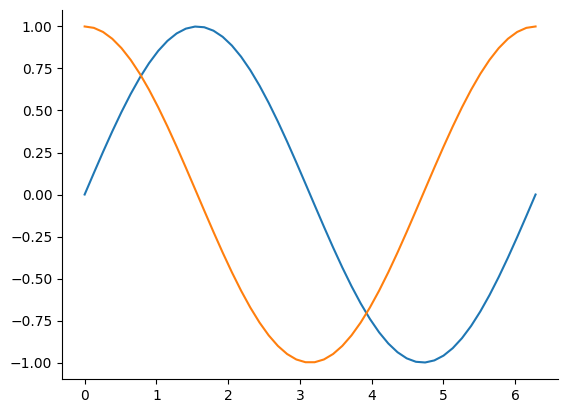

In [6]:
plt.plot(x, f(x))
plt.plot(x, vmap(grad(f))(x))

### 4. Compilation: `jit`

You can use the XLA (accelerated linear algebra) compiler to compile your functions with `jax.jit`.

In [7]:
def f(x):
    return x * x + x * 2.0

x = jnp.ones((5000, 5000))

In [8]:
%timeit f(x)

62.7 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
jit_f = jit(f)
%timeit jit_f(x)

25.4 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Putting perception into action: Inverse optimal control for continuous psychophysics

## Modeling a tracking task with LQG control

The LQG control problem is defined by a linear-Gaussian stochastic dynamical system
$$
\mathbf x_{t+1} = A \mathbf x_t + B \mathbf u_t + V \mathbf \epsilon_t, \; \mathbf\epsilon_t \sim \mathcal{N}(0, I),
$$

a linear-Gaussian observation model
$$
\mathbf y_t = C \mathbf x_t + W \mathbf \eta_t, \; \mathbf\eta_t \sim \mathcal{N}(0, I),
$$

and a quadratic cost function

$$
J = \sum_t \mathbf x_t^T Q \mathbf x_t + \mathbf u_t^T R \mathbf u_t.
$$

We assume that the actor solves the linear-quadratic Gaussian problem, i.e. computes the Kalman filter $K$ and the LQR control law $L$, which are the optimal solution under the quadratic cost function

$$
J(u_{1:T}) =  \sum_{t=1}^T \mathbf x_t^T Q \mathbf x_t + \mathbf u_t^T R \mathbf u_t.
$$

We start by defining the matrices $A, B, C, V, W, Q, R$ as `jax.numpy.array`s. according to our simple model of the continuous psychophysics tracking task:

$$
A = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}, 
\; B = \begin{bmatrix}
0 \\
dt
\end{bmatrix},
\; C = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}, \\
V = \begin{bmatrix}
\sigma_\text{rw} & 0 \\
0 & \sigma_\text{act}
\end{bmatrix}, 
\; W = \begin{bmatrix}
\sigma & 0 \\
0 & \sigma_\text{cursor}
\end{bmatrix}, \\
Q = \begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}, \; R = \begin{bmatrix}
c
\end{bmatrix}.
$$

In [10]:
action_variability = 0.5
sigma_target = 6.
sigma_cursor = 1.
action_cost = .05

dt = 1. / 60.

# dynamical system
A = jnp.eye(2)
B = jnp.array([[0.], 
              [dt]])

# noise
V = jnp.diag(jnp.array([1., action_variability]))

# observation model
C = jnp.eye(2)
W = jnp.diag(jnp.array([sigma_target, sigma_cursor]))

# cost function
Q = jnp.array([[1., -1.],
              [-1., 1]])

R = jnp.eye(1) * action_cost

T = 500
model = LQG(A, B, C, V, W, Q, R, T=T)

The `System` class, which `LQG` extends, can be pretty-printed. When calling `display(model)`, the matrices of your model will be displayed as $\LaTeX$ math formula. The same happens when the output of a cell is printed. Standard (i.e., not so pretty) printing can still be achieved through `print(model)`.

In [11]:
model  # equivalent to `display(model)`

Let's simulate some tracking data by applying the Kalman filter and linear-quadratic regular. This is implemented in the method `simulate(rng_key, n, T)`. Since `jax` does not have a global random number generator state, we need to pass a `PRNGKey` object. `n` is the number of trials and `T` is the number of time steps.

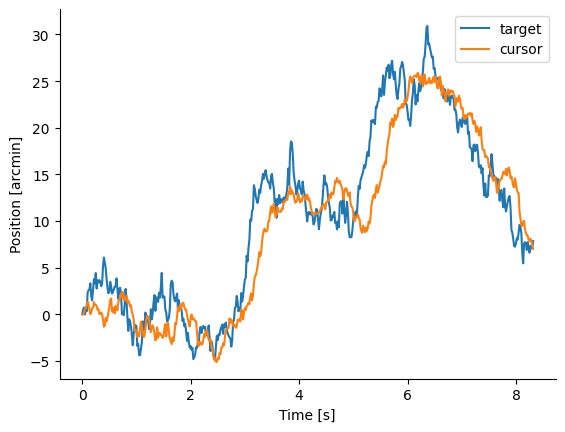

In [12]:
x = model.simulate(random.PRNGKey(0), n=100)

plt.plot(jnp.arange(T) * dt, x[0, :, 0], label="target")
plt.plot(jnp.arange(T) * dt, x[0, :, 1], label="cursor")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Position [arcmin]")
plt.show()

In [13]:
x.shape

(100, 500, 2)

## Cross-correlograms

We can also look at the correlation between the velocities of the target and the cursor at different time lags. This analysis is known as a cross-correlogram (Mulligan et al., 2013) and computes the average autocorrelation of the velocities of target and response.

Text(0, 0.5, 'Cross-correlation')

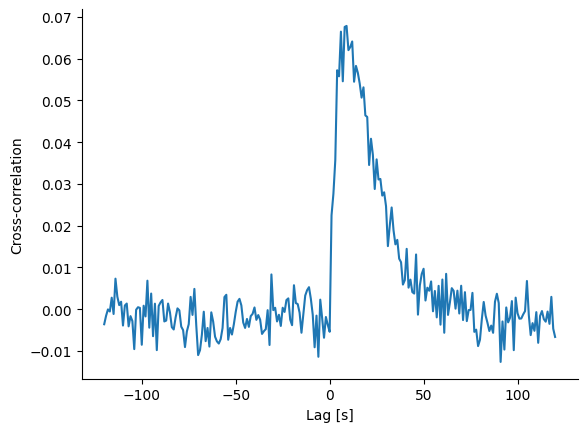

In [14]:
vels = jnp.diff(x, axis=1)
lags, correls = xcorr(vels[...,1], vels[...,0], maxlags=120)

plt.plot(lags, correls.mean(axis=0))
plt.xlabel("Lag [s]")
plt.ylabel("Cross-correlation")

## Influence of model parameters

To look a the influence of the different model parameters, we define a class that inherits from the `LQG` base class and defines the matrices given the four parameters.

In [15]:
class BoundedActor(LQG):
    def __init__(self, 
               sigma_target, 
               action_variability, 
               action_cost, 
               sigma_cursor):

        dt = 1. / 60.

        A = jnp.eye(2)
        B = jnp.array([[0.], 
                      [dt]])

        V = jnp.diag(jnp.array([1., action_variability]))

        F = jnp.eye(2)
        W = jnp.diag(jnp.array([sigma_target, sigma_cursor]))


        Q = jnp.array([[1., -1.],
                      [-1., 1]])

        R = jnp.eye(1) * action_cost


        super().__init__(A=A, B=B, F=F, V=V, W=W, Q=Q, R=R, T=T)

We can now simulate data from the model given the four parameters. To do this efficiently, we `jit`-compile the simulation function.

Some observations:
- An increase in action costs leads to an increased lag and decreased maximum correlation.
- An increase in perceptual uncertainty about the target leads to decreased correlation and increased lag, too, but the shape of the curves changes differently compared to the effect of the behavioral cost.
- Action variability does not change the lag, but decreases correlation overall.
- Perceptual uncertainty about the cursor does not change the shape of the CCGs at all, but does increase the mean squared error between target and response.

In [16]:
# @jit # jit-compile the simulation part to speed up our interactive widget
# def simulate_trajectories(sigma_target,
#                           action_cost,
#                           action_variability, 
#                           sigma_cursor):
#     model = BoundedActor(sigma_target=sigma_target, 
#                        action_variability=action_variability,
#                        action_cost=action_cost, 
#                        sigma_cursor=sigma_cursor)

#     x = model.simulate(random.PRNGKey(0), n=100)

#     return x

# style = {"description_width": "200px"}
# layout = {'width': '400px'}

# @interact(sigma_target=widgets.FloatLogSlider(min=-1, max=2, value=10., 
#                                        style=style, layout=layout,
#                                        description="Perceptual uncertainty (target)"), 
#           action_cost=widgets.FloatLogSlider(min=-2, max=1, value=1., 
#                                    style=style, layout=layout,
#                                    description="Behavioral costs"),
#           action_variability=widgets.FloatSlider(min=.1, max=2., value=.5, 
#                                       style=style, layout=layout,
#                                       description="Action variability"),
#           sigma_cursor=widgets.FloatLogSlider(min=-1, max=2, value=1., 
#                                          style=style, layout=layout,
#                                        description="Perceptual uncertainty (cursor)"))
# def plot_trajectory(sigma_target, action_cost, action_variability, sigma_cursor):

#     x = simulate_trajectories(sigma_target, action_cost, action_variability, sigma_cursor)

#     f, ax = plt.subplots(1, 2, figsize=(8., 4.))
#     ax[0].plot(jnp.arange(T) / 60, x[0, :, 0])
#     ax[0].plot(jnp.arange(T) / 60, x[0, :, 1])
#     ax[0].set_ylim(-30, 30)
#     ax[0].set_title("Trajectory")
#     ax[0].set_xlabel("Time [s]")
#     ax[0].set_ylabel("Position [arcmin]")

#     # cross-correlograms
#     vels = jnp.diff(x, axis=1)
#     lags, correls = xcorr(vels[...,1], vels[...,0], maxlags=120)

#     ax[1].plot(lags / 60, correls.mean(axis=0))
#     ax[1].set_ylim(-.01, .1)
#     ax[1].set_title("Cross-correlogram")
#     ax[1].set_ylabel("Correlation")
#     ax[1].set_xlabel("Time lag [s]")

#     f.tight_layout()

## Subjective internal models

The dynamical system that defines the experiment (i.e. the target movement) might not be known to the agent. In that case, we can assume that the agent has their own subjective internal model, which may differ from the true model.

For example, instead of the true random walk

$$
x_{t+1} = x_t + \sigma_\text{rw} * \epsilon_t,$$

the agent could assume that there is a velocity component to the random walk

$$
x_{t+1} = x_t + dt * v_t + \sigma_s * \epsilon_t \\
v_{t+1} = v_t + \sigma_v * \varepsilon_t.
$$

Let's simulate this and compare it to the random walk on position that was used in the experiment.

In [17]:
# @interact(sigma_s=widgets.FloatSlider(min=0., max=2., value=1.,
#                                       style=style, layout=layout,
#                                        description="Subjective std"), 
#           sigma_v=widgets.FloatSlider(min=0., max=2., value=0., 
#                                    style=style, layout=layout,
#                                    description="Subjective vel std"))
# def simulate_random_walks(sigma_s, sigma_v):
#     T = 100
#     n = 20
#     dt = 1. / 60.

#     key_s, key_v = random.split(random.PRNGKey(123))
#     x_true = jnp.cumsum(random.normal(key_s, shape=(T, n)), axis=0)

#     v = jnp.cumsum(random.normal(key_v, shape=(T, n)) * sigma_v, axis=0)
#     x = jnp.cumsum(random.normal(key_s, shape=(T, n)) * sigma_s + dt * v, axis=0)

#     f, ax = plt.subplots(1, 2, sharey=True, sharex=True)
#     ax[0].plot(x_true)
#     ax[0].set_title("Actual random walk")
#     ax[0].set_xlabel("Time step")
#     ax[0].set_ylabel("Position")
#     ax[1].plot(x)
#     ax[1].set_title("Subjective random walk")
#     ax[1].set_xlabel("Time step")
#     f.show()

We now define a class for the subjective actor. We need to distinguish between the matrices of the actual dynamical system of the experiment and those of the subjective internal model of the agent. This is possible in the `lqg` package by defining a `Dynamics` and an `Actor` object and combining them into a `System`.

In [18]:
class SubjectiveActor(System):
    def __init__(self, 
               sigma_target, 
               action_variability, 
               action_cost, 
               sigma_cursor,
               sigma_s, 
               sigma_v):

        dt = 1. / 60.

        # true dynamical system (same as above)
        A = jnp.eye(2)
        B = jnp.array([[0.], [dt]])
        V = jnp.diag(jnp.array([1., action_variability]))

        C = jnp.eye(2)
        W = jnp.diag(jnp.array([sigma_target, sigma_cursor]))

        dynamics = Dynamics(A, B, C, V, W, T=T)

        # subjective dynamical system parameters
        A_subj = jnp.array([[1., 0., dt],  # target position
                            [0., 1., 0.],  # cursor position
                            [0., 0., 1.]]) # target velocity
        B_subj = jnp.array([[0.], [dt], [0.]])
        C_subj = jnp.array([[1., 0., 0.],
                            [0., 1., 0.]])
        V_subj = jnp.diag(jnp.array([sigma_s, action_variability, sigma_v]))

        # cost function
        Q = jnp.array([[1., -1., 0.],
                    [-1., 1., 0.],
                    [0., 0., 0.]])

        R = jnp.eye(1) * action_cost

        actor = Actor(A_subj, B_subj, C_subj, V_subj, W, Q, R, T=T)

        super().__init__(actor=actor, dynamics=dynamics)

In [19]:
# @jit # jit-compile the simulation part to speed up our interactive widget
# def simulate_subjective_actor(sigma_s, sigma_v):

#     model = SubjectiveActor(action_variability=0.5,
#                           action_cost=0.05,
#                           sigma_target=6.,
#                           sigma_cursor=3.,
#                           sigma_s=sigma_s,
#                           sigma_v=sigma_v)
#     x = model.simulate(random.PRNGKey(0), x0=jnp.zeros(2), n=100)

#     return x

# @interact(sigma_s=widgets.FloatSlider(min=0., max=2., value=1., 
#                                        style=style, layout=layout,
#                                        description="Subjective std"), 
#           sigma_v=widgets.FloatSlider(min=0., max=2., value=0., 
#                                    style=style, layout=layout,
#                                    description="Subjective vel std"))
# def plot_trajectory(sigma_s, sigma_v):

#     x = simulate_subjective_actor(sigma_s, sigma_v)

#     f, ax = plt.subplots(1, 2, figsize=(8., 4.))
#     ax[0].plot(jnp.arange(T) / 60, x[0, :, 0])
#     ax[0].plot(jnp.arange(T) / 60, x[0, :, 1])
#     ax[0].set_ylim(-30, 30)
#     ax[0].set_title("Trajectory")
#     ax[0].set_xlabel("Time [s]")
#     ax[0].set_ylabel("Position [arcmin]")

#     # cross-correlograms
#     vels = jnp.diff(x, axis=1)
#     lags, correls = xcorr(vels[...,1], vels[...,0], maxlags=120)

#     ax[1].plot(lags / 60, correls.mean(axis=0))
#     ax[1].set_ylim(-.03, .1)
#     ax[1].set_title("Cross-correlogram")
#     ax[1].set_ylabel("Correlation")
#     ax[1].set_xlabel("Time lag [s]")

#     f.tight_layout()

For the models from the paper, I have defined classes with the corresponding names in `lqg.tracking`.

# Inverse optimal control

## Likelihood function

To compute the likelihood

$$
p(\mathbf x_{1:T} \mid \theta) = \prod_{i=1}^{T-1} p(\mathbf x_{t+1} \mid \mathbf x_{1:t}, \theta),
$$

we need to marginalize out the latent variables $\hat{\mathbf x}_{1:T}$ (the agent's internal beliefs). We can do this efficiently in the LQG setting by starting with our belief about the agent's belief $p(\hat{\mathbf x}_t \mid \mathbf x_{1:t})$ and then iteratively performing the following steps:

1. Propagate the uncertainty about the agent's belief through the joint dynamical system of states and beliefs
$$
p(\hat{\mathbf{x}}_{t+1}, \mathbf x_{t+1} \mid \mathbf x_{1:t}, \theta) =  \int p(\hat{\mathbf{x}}_{t+1}, \mathbf x_{t+1} \mid \hat{\mathbf{x}}_{t}, \mathbf x_{t}, \theta) p(\hat{\mathbf{x}}_{t} \mid \mathbf x_{1:t}, \theta) d \hat{\mathbf{x}}_{t}
$$
2. Marginalize over the agent's belief
$$
p(\mathbf x_{t+1} \mid \mathbf x_{1:t}, \theta) = \int p(\hat{\mathbf{x}}_{t+1}, \mathbf x_{t+1} \mid \mathbf x_{1:t}, \theta) d \hat{\mathbf x}_{t+1}$$
3. Condition on the observed state
$$
p(\hat{\mathbf{x}}_{t+1} \mid \mathbf x_{1:t+1}, \theta) = \frac{p(\hat{\mathbf{x}}_{t+1}, \mathbf x_{t+1} \mid \mathbf x_{1:t}, \theta)}{p(\mathbf x_{t+1} \mid \mathbf x_{1:t}, \theta)}
$$

This gives us the contributions to the likelihood at each time step $p(\mathbf x_{t+1} \mid \mathbf x_{1:t}, \theta)$ (2.) and the distribution over the agent's belief for the next time step $p(\hat{\mathbf{x}}_{t+1} \mid \mathbf x_{1:t+1}, \theta)$ (3.).

This algorithm for computing the likelihood is implemented in the method `log_likelihood(x)` of our LQG class.

In [20]:
true_params = dict(sigma_target=25., 
                   action_variability=0.5, 
                   action_cost=0.5, 
                   sigma_cursor=3.)

# simulate some data
model = BoundedActor(**true_params)
x = model.simulate(random.PRNGKey(123), n=50)

Text(0.5, 1.0, 'Log likelihood')

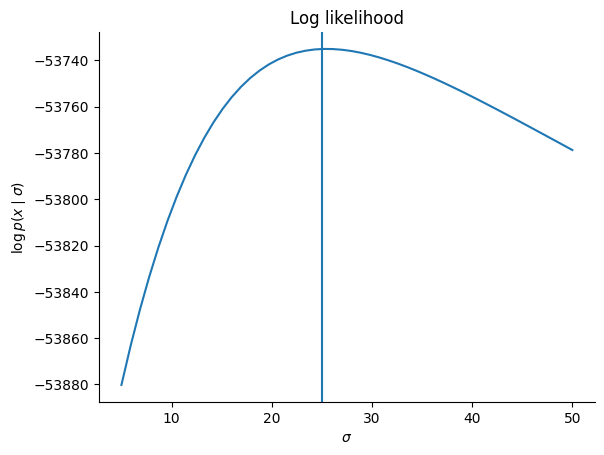

In [21]:
# log likelihood of one parameter, keeping others constant at the true value
def ll(sigma):
    return BoundedActor(sigma_target=sigma, 
                      action_variability=true_params["action_variability"], 
                      action_cost=true_params["action_cost"],
                      sigma_cursor=true_params["sigma_cursor"]
                      ).log_likelihood(x).sum()
                      
# range of parameter values
sigmas = jnp.linspace(5., 50.)

plt.plot(sigmas, vmap(ll)(sigmas))
plt.axvline(25.)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\log p(x \mid \sigma)$")
plt.title("Log likelihood")

We could also do gradient-based optimization of the log likelihood function by using `jax`'s automatic differentiation tools.

In [22]:
grad(ll)(28.)

Array(-0.71183217, dtype=float32, weak_type=True)

## Bayesian inference with NumPyro

In Bayesian inverse optimal control, we are interested in the posterior distribution of the model parameters given a trajectory

$$
p(\theta \mid \mathbf x_{1:T}) \propto p(\mathbf x_{1:T} \mid \theta) \, p(\theta).
$$

To sample from this posterior distribution, we will use `numpyro`, a probabilistic programming package powered by `jax`. For every random variable in the model (in our case the parameters and the observed data), we need to call `numpyro.sample` to define a name and a distribution.

In [23]:
def lqg_model(x):

    # priors
    action_variability = numpyro.sample("action_variability", dist.HalfCauchy(1.))
    action_cost = numpyro.sample("action_cost", dist.HalfCauchy(1.))
    sigma_target = numpyro.sample("sigma_target", dist.HalfCauchy(50.))
    sigma_cursor = numpyro.sample("sigma_cursor", dist.HalfCauchy(15.))

    # setup model
    model = BoundedActor(action_variability=action_variability,
                       action_cost=action_cost,
                       sigma_target=sigma_target,
                       sigma_cursor=sigma_cursor)

    # likelihood
    numpyro.sample("x", model.conditional_distribution(x),
                  obs=x[:, 1:])

In [24]:
nuts_kernel = NUTS(lqg_model)

mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), x)

sample: 100%|██████████| 1500/1500 [05:15<00:00,  4.76it/s, 15 steps of size 4.00e-01. acc. prob=0.93] 


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


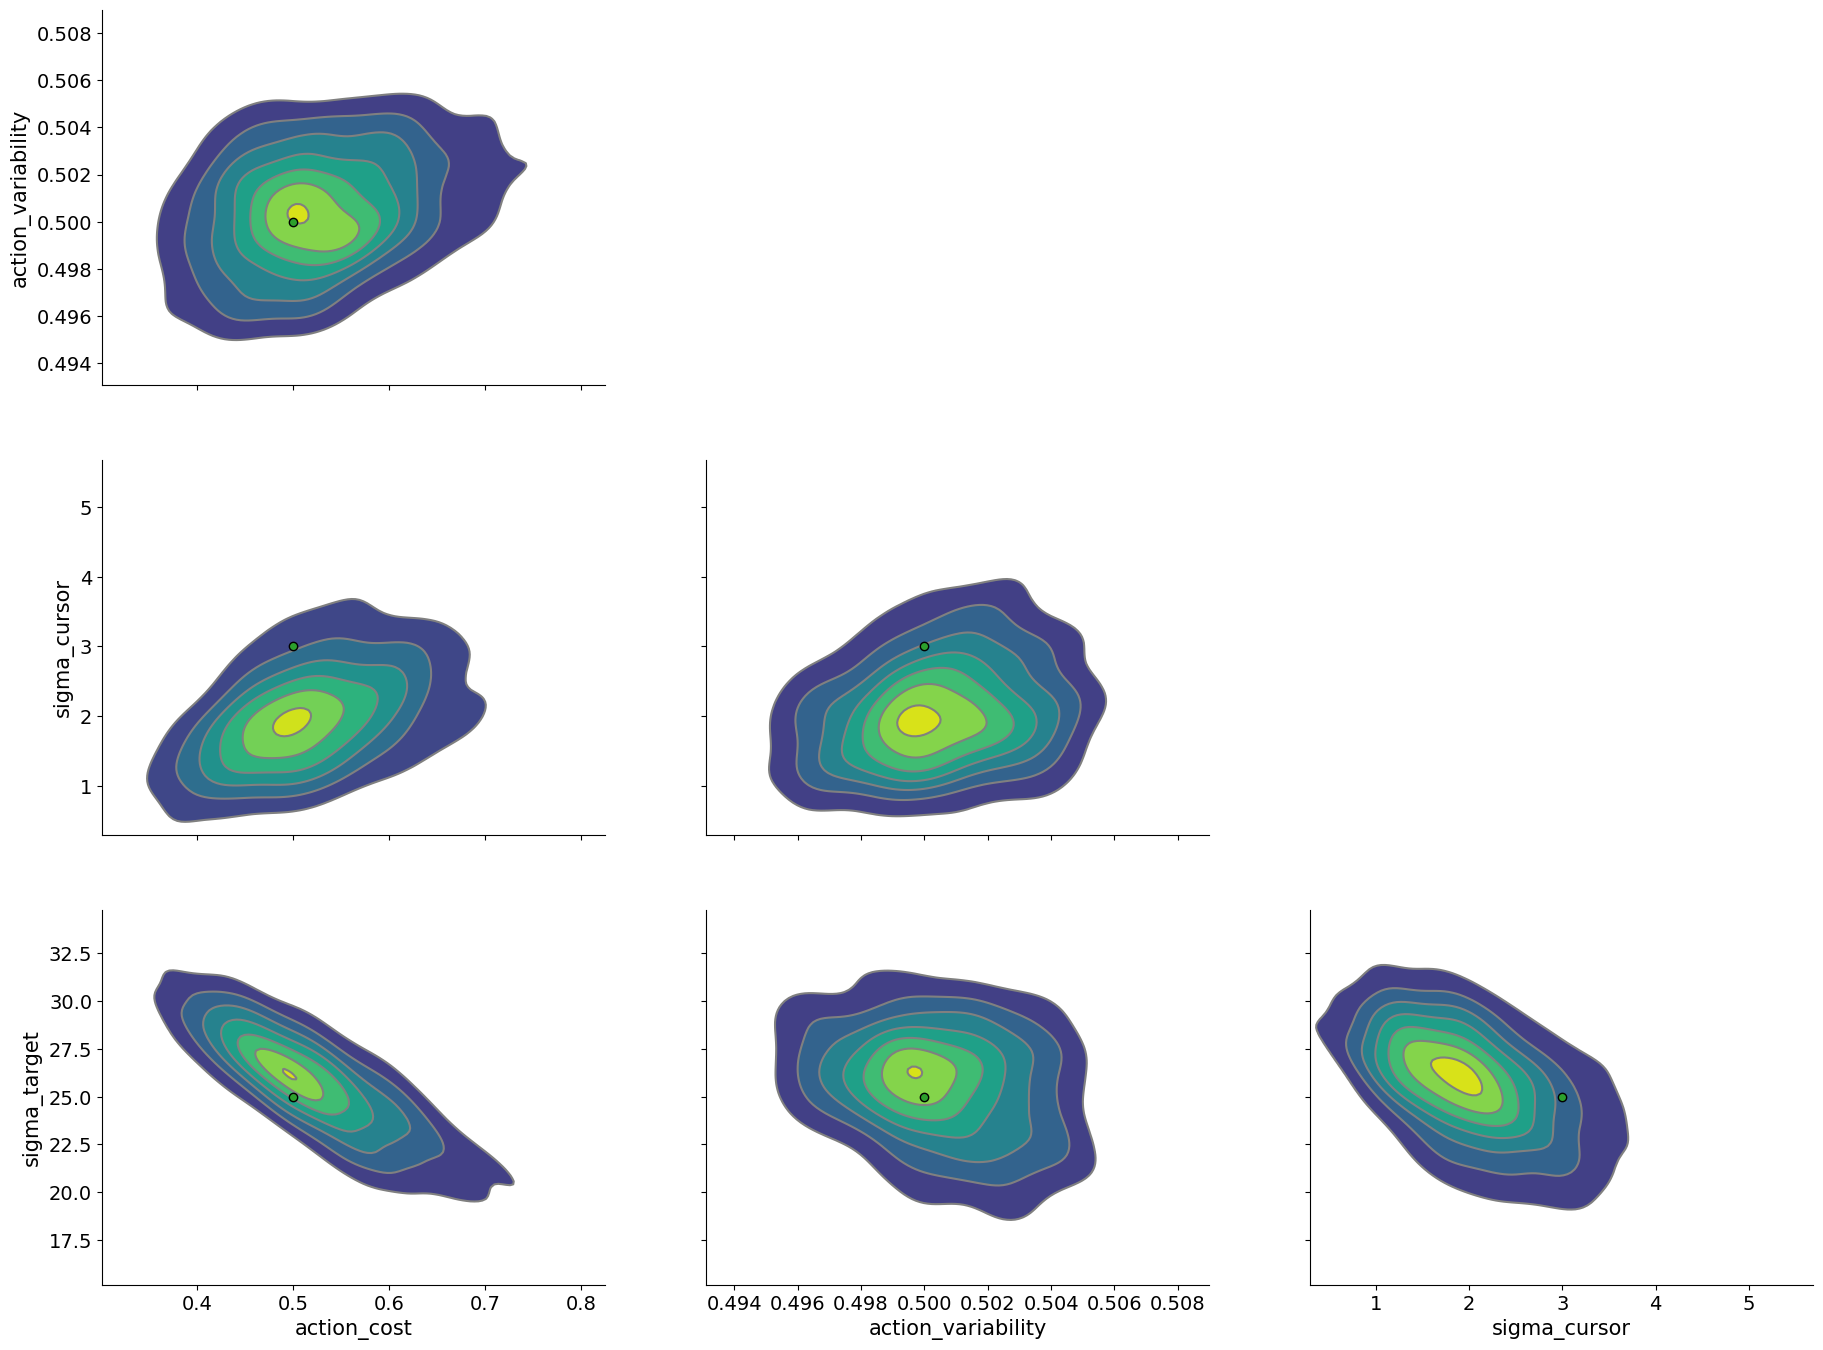

In [25]:
inference_data = az.from_numpyro(mcmc)

az.plot_pair(inference_data, reference_values=true_params, kind="kde")

summary = az.summary(inference_data)

## Belief tracking

Once we have fit the model, we can use it to do belief tracking: We compute the probabilitiy distribution 

$$
p(\hat{\mathbf x}_t | \mathbf x_{1:t}),
$$

i.e. the researcher's uncertainty about the agent's belief.

In [26]:
model = BoundedActor(**summary["mean"].to_dict())

x = model.simulate(random.PRNGKey(1), n=100)

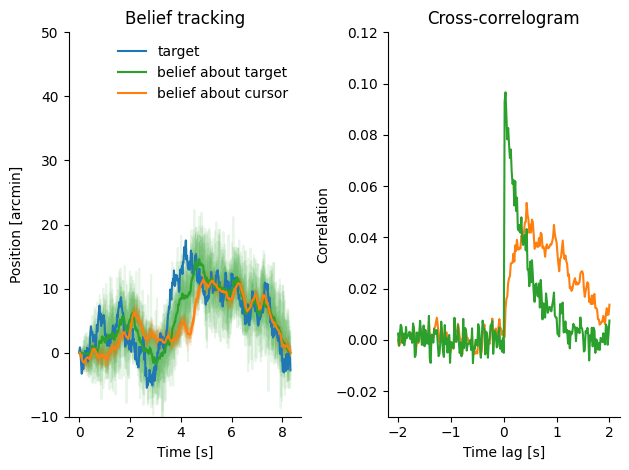

In [27]:
d = model.belief_tracking_distribution(x)
belief_samples = d.sample(random.PRNGKey(0), sample_shape=(10,))
belief_mean = d.loc # get mean of belief distribution

f, ax = plt.subplots(1, 2)
ax[0].plot(jnp.arange(500) / 60, x[1, :, 0], label="target")
ax[0].plot(jnp.arange(1, 500) / 60, belief_mean[1, :, 0], label="belief about target", color="C2")
ax[0].plot(jnp.arange(1, 500) / 60, belief_mean[1, :, 1], label="belief about cursor", color="C1")

for i in range(10):
    ax[0].plot(jnp.arange(1, 500) / 60, belief_samples[i, 1, :, 0],
          color="C2", alpha=0.1, zorder=-1)
    ax[0].plot(jnp.arange(1, 500) / 60, belief_samples[i, 1, :, 1],
          color="C1", alpha=0.1, zorder=-1)
ax[0].set_ylim(-10, 50)
ax[0].set_title("Belief tracking")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Position [arcmin]")
ax[0].legend(frameon=False)

# cross-correlograms with belief about cursor
lags, correls = xcorr(jnp.diff(belief_mean[..., 1], axis=1),
                      jnp.diff(x[..., 0], axis=1), maxlags=120)

ax[1].plot(lags / 60, correls.mean(axis=0), color="C1")

# cross-correlograms with belief about target
lags, correls = xcorr(jnp.diff(belief_mean[..., 0], axis=1),
                      jnp.diff(x[..., 0], axis=1), maxlags=120)

ax[1].plot(lags / 60, correls.mean(axis=0), color="C2")

ax[1].set_ylim(-.03, .12)
ax[1].set_title("Cross-correlogram")
ax[1].set_ylabel("Correlation")
ax[1].set_xlabel("Time lag [s]")

f.tight_layout()